# Building a Fantasy World

In [482]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors as cmod
import subprocess as sub

from scipy.integrate import ode

from scipy.interpolate import interp2d

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.patches as mpatches


from matplotlib.animation import PillowWriter  


from scipy.spatial.transform import Rotation as R

In [2]:
from geofuns import *
from FantasyWorld import *
from plotting import *
# from race import *

In [3]:
%matplotlib inline

## Geography

We need to build the globe and landforms, figure out mountains/lakes/rivers, and finally biomes - desert, forest, tundra, etc. in some rational way. We start with elevation, then add temperature and (high level) wind formations, and finally moisture. Combine those to make biomes.

Initialize the globe mesh. We can paramterize the surface of planet with spherical coordinates, and then compute (surface) distance between points.

In [4]:
#     Rearth = 3958 #Radius of the earth
GS =100
World1 = FantasyWorld(GridSize = GS,oLevel = 0.4)

In [5]:
MapTheta = mapThetas(World1.GlobeGrid)

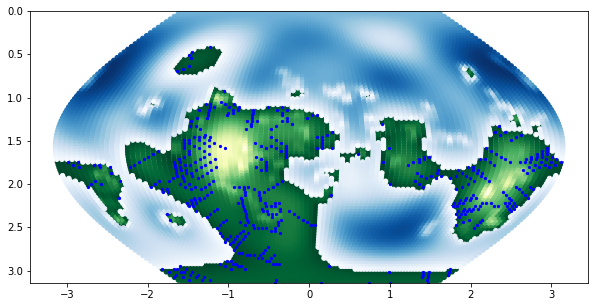

In [6]:
RiverMsk = World1.RiverIndicator.reshape(World1.GridSize)

fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')

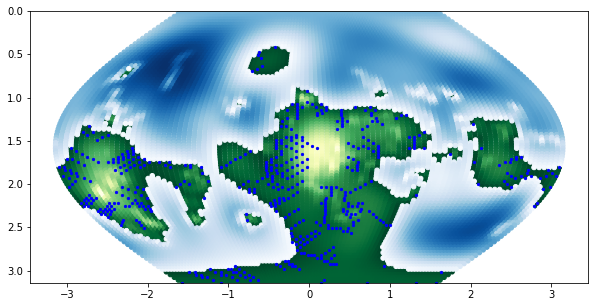

In [7]:
RotateView(World1,0.52*np.pi)

In [8]:
np.save("Elevation",World1.Elevation)
np.save("GlobeMesh",World1.GlobeGrid)
np.save("Temps",World1.Temps[1])

sub.run("python sphere.py GlobeMesh.npy Elevation.npy Temps.npy")

CompletedProcess(args='python sphere.py GlobeMesh.npy Elevation.npy Temps.npy', returncode=0)

## Temperature & Rainfall

We determine average winter and summer temperatures using latitude, elevation, and distance from the ocean. We then add prevailing winds and use those to determine final temperature.

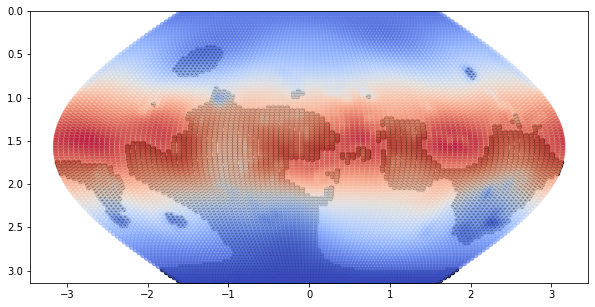

In [9]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = 'k', cmap = 'YlGn_r')
ax.scatter(MapTheta,World1.GlobeGrid[0],s=20,c = World1.Temps[1], cmap = 'coolwarm', alpha = 0.6)#, norm = normwet)

To visualize wind, we can use a basis for the tangent space to a sphere based on latitude and longitued:

In [10]:
phi = np.linspace(0,np.pi,30)
theta = np.linspace(-np.pi,np.pi,30)
smallGlobeGrid = np.meshgrid(phi,theta)

smallMapThetas =  mapThetas(smallGlobeGrid)
windph,windth = visWind(World1,smallGlobeGrid)


        

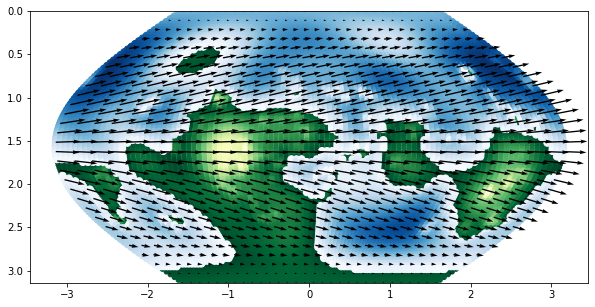

In [11]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=50,c =  World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.quiver(smallMapThetas,smallGlobeGrid[0],windth,windph,scale_units = 'xy', scale = 5)

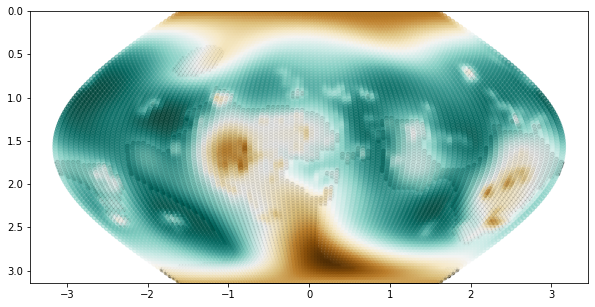

In [12]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = 'k')
ax.scatter(MapTheta,World1.GlobeGrid[0],s=30,c = World1.RainFall, cmap = 'BrBG', alpha = 0.6)#, norm = normwet)

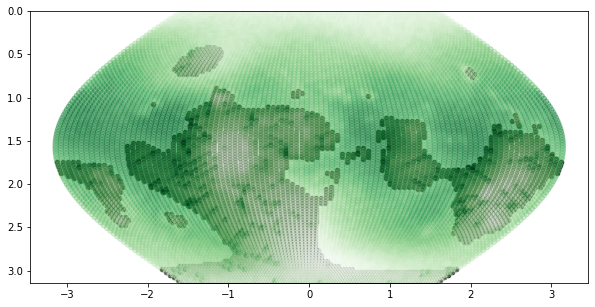

In [13]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = 'k')
ax.scatter(MapTheta,World1.GlobeGrid[0],s=30,c = World1.InitialRenew, cmap = 'Greens', alpha = 0.4)#, norm = normwet)

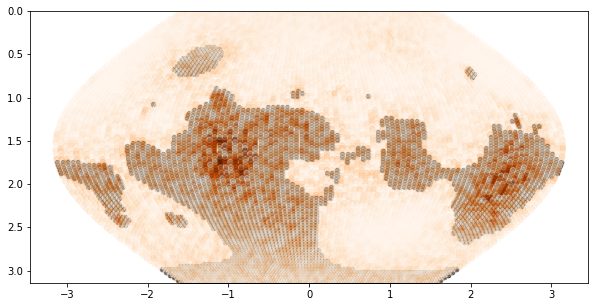

In [14]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = 'k')
ax.scatter(MapTheta,World1.GlobeGrid[0],s=30,c = World1.InitialNonRenew, cmap = 'Oranges', alpha = 0.4)#, norm = normwet)

## Population Demographics Simulation

Save the initial world state

So that we may reset the world

In [15]:
np.sum(World1.Renewables*World1.NonRenewables)/np.sum(World1.LandIndicator)

18.428518161963932

In [16]:
ThePops = ['humans','orcs','elves','dwarves']
numPops = len(ThePops)

In [17]:
Starters = [World1.RiverIndices[np.random.choice(len(World1.RiverIndices))] for r in range(numPops)]

In [18]:
TestPop = np.zeros((numPops,*World1.GridSize))

In [19]:
for st in range(len(Starters)):
    TestPop[st,Starters[st][0],Starters[st][1]] = 0.1

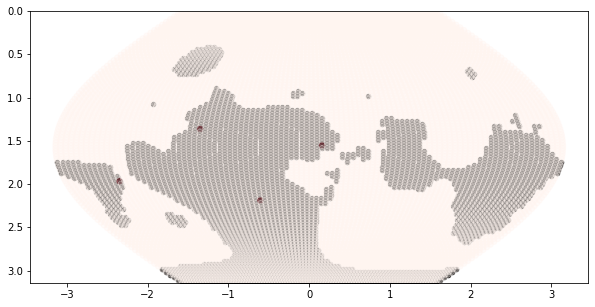

In [20]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = 'k')
ax.scatter(MapTheta,World1.GlobeGrid[0],s=30,c = np.sum(TestPop,axis = 0), cmap = 'Reds', alpha = 0.4)#, norm = normwet)

In [21]:
def GrowthSys(t,y,params):
    [kappas,gammas,alpha,R0,beta1s,beta2s,numpops] = params
    pops = y[:kappas.size]
    renews = y[kappas.size:kappas.size+alpha.size]
    nonrenews =  y[kappas.size+alpha.size:]
    popsDot = kappas*pops*np.array([renews]*numpops).flatten()*np.array([nonrenews]*numpops).flatten() - gammas*pops
    rdot = alpha*(R0-renews) - np.sum((beta1s*popsDot).reshape(numpops,alpha.size), axis = 0)
    ndot =  - np.sum((beta2s*popsDot).reshape(numpops,alpha.size), axis = 0)
    return np.concatenate([popsDot.flatten(),rdot.flatten(),ndot.flatten()])

In [22]:
def MoveAround(t,y,params):
    desire,neighborkey = params
    ysum = np.array([sum(y[ne]) for ne in neighborkey])
    desiresum = np.array([sum(desire[ne]) for ne in neighborkey])
    dot = desire*ysum - y*desiresum
    return dot
    

In [23]:
def TotChange(t,y,params):
    grwthParams,moveParams,speeds = params
    numpops = len(moveParams)
    dot = GrowthSys(t,y,grwthParams)
    for i in range(numpops):
        dot[i*len(moveParams[i][0]):(i+1)*len(moveParams[i][0])] = dot[i*len(moveParams[i][0]):(i+1)*len(moveParams[i][0])] + speeds[i]*MoveAround(t,y[i*len(moveParams[i][0]):(i+1)*len(moveParams[i][0])],moveParams[i])
    return dot

In [24]:
def GetNeighbors(l,size):
    if np.array(np.unravel_index(l,size))[1] == 0:
        return [np.ravel_multi_index((j,1),size) for j in range(size[1])]
    elif np.array(np.unravel_index(l,size))[1] == size[1]-1:
        return [np.ravel_multi_index((j,size[1]-1),size) for j in range(size[1])]
    else:
        return [np.ravel_multi_index(np.remainder(np.array(np.unravel_index(l,(100,100))) + [i,j],[size[0],size[1]+10]),size) for i in [-1,0,1] for j in [-1,0,1]]

In [25]:
class Demographics:
    def __init__(self,racenames,initialPop,baseKappas,baseGammas,basebeta1s,basebeta2s,mvspeeds,chngFun):
        self.Races = racenames
        
        self.Populations = initialPop
        
        self.kappas = np.array([[[bk]*initialPop.shape[1]]*initialPop.shape[2] for bk in baseKappas]).flatten()
        self.gammas = np.array([[[bg]*initialPop.shape[1]]*initialPop.shape[2] for bg in baseGammas]).flatten()
        self.beta1s = np.array([[[bb1]*initialPop.shape[1]]*initialPop.shape[2] for bb1 in basebeta1s]).flatten()
        self.beta2s = np.array([[[bb2]*initialPop.shape[1]]*initialPop.shape[2] for bb2 in basebeta2s]).flatten()
        
        self.Chromosome = np.random.rand(len(racenames))
        
        self.History = dict([(racenames[i],[initialPop[i]]) for i in range(len(racenames))] + [("total",[np.sum(initialPop,axis = 0)])] + [("time",[0])])
        
        self.ChangeFun = chngFun
        
        self.PreferredTemp = 0.75*np.ones(len(racenames))
        self.PreferredCrowd = np.ones(len(racenames))
        
        self.MovementSpeeds = mvspeeds
        
        self.Disasters = []
        self.Migrations = []
        
    def Desire(self,world):
        ResourceDesire =(world.Renewables + world.NonRenewables)/np.max(world.Renewables+ world.NonRenewables)
        TempDistSummer = np.array([dt - world.Temps[1] for dt in self.PreferredTemp])**2
        TempDistWinter = np.array([dt - world.Temps[0] for dt in self.PreferredTemp])**2
        TempDistSummer = 1 - TempDistSummer/np.max(TempDistSummer)
        TempDistWinter = 1 - TempDistWinter/np.max(TempDistWinter)
        TempDesire = (TempDistSummer + TempDistWinter)/2
        CrowdDist = np.array([prc - np.sum(self.Populations,axis = 0)/np.sum(self.Populations) for prc in self.PreferredCrowd])**2
        CrowdDesire = CrowdDist/np.max(CrowdDist)
        BasicDesire = (np.array([ResourceDesire]*len(self.Races)) + TempDesire + CrowdDesire)/3
        RiverAdj = BasicDesire*(0.1*np.array([world.RiverIndicator.reshape(world.GridSize).astype(float)]*len(self.Races)) + np.ones_like(BasicDesire))
        return (RiverAdj/np.max(RiverAdj))*np.array([world.LandIndicator.astype(float)]*len(self.Races))
        
            
    def ChangePop(self,world,dt = 0.1):
        grwall = ode(self.ChangeFun)
        grwall.set_initial_value(np.concatenate([self.Populations.flatten(),world.Renewables.flatten(),world.NonRenewables.flatten()]),0)
        desires = self.Desire(world)
        mvParams = [[des.flatten(),world.neighborkey] for des in desires]
        all_params = [[self.kappas,self.gammas,world.renewrate.flatten(),world.InitialRenew.flatten(),self.beta1s,self.beta2s,len(self.Races)],mvParams,self.MovementSpeeds]
        grwall.set_f_params(all_params)
        result = grwall.integrate(dt)
        newPops = result[:self.Populations.size].reshape(self.Populations.shape)
        newRenews = result[self.Populations.size:self.Populations.size + world.GlobeGrid[0].size].reshape(world.GridSize)
        newNon = result[self.Populations.size + world.GlobeGrid[0].size:].reshape(world.GridSize)
        for r in range(len(self.Races)):
            self.History[self.Races[r]] += [newPops[r,:,:]]
        self.History["total"] += [np.sum(newPops,axis = 0)]
        self.History["time"] += [self.History["time"][-1] + dt]
        self.Populations = newPops
        return newRenews,newNon
    

    def NaturalDisaster(self):
        whrind = np.random.randint(np.sum(self.History["total"][-1].astype(bool)))
        location = np.argwhere(self.History["total"][-1])[whrind]
        damage = 0.5*np.random.rand()
        for r in range(len(self.Races)):
            self.Populations[r,location[0],location[1]] = (1-damage)*self.Populations[r,location[0],location[1]]
        self.Disasters += [{"time":self.History["time"][-1],"location":location,"damage":damage}]
        
    def Migration(self,world):
        iii = np.random.choice(len(self.Races))
        whichRace = self.Races[iii]
        loc1 = np.random.choice(self.Populations[iii].size,p = self.Populations[iii].flatten().round(5)/np.sum(demos.Populations[iii].flatten().round(5)))
        loc1 = np.unravel_index(loc1,demos.Populations[iii].shape)
        loc1Spher = (world.GlobeGrid[0][loc1],world.GlobeGrid[1][loc1])
        loc1cart = toCart(*loc1Spher,1)
        time = self.History["time"][-1]
        mean_dist = min(np.pi*time/(0.001*world.Radius),np.pi/2)
        dist = min(np.random.exponential(mean_dist),np.pi)
        
        #a first vector on the circle
        if loc1Spher[0] + dist < np.pi:
            strt = (loc1Spher[0]+dist,loc1Spher[1])
        else:
            if loc1Spher[1] <0:
                strt = (2*np.pi - loc1Spher[0]+dist,loc1Spher[1] + np.pi)
            else:
                strt = (2*np.pi - loc1Spher[0]+dist,loc1Spher[1] - np.pi)
                
        strtC = toCart(*strt,1)
        
        #where on the circle:
        rot = 2*np.pi*np.random.rand()
        
        #rotate the start about the center of circle:
        rotation = R.from_rotvec(rot*np.array(loc1cart))
        finalCart = rotation.apply(strtC)
        
        finalSphere = toSphere(*finalCart)
        
        loc2 = (np.where(world.GlobeGrid[1][:,0] > finalSphere[2])[0][0],np.where(world.GlobeGrid[0][0] > finalSphere[1])[0][0])
        if world.LandIndicator(loc2):      
            prop_of_pop = 0.5*np.random.rand()
            size = self.Populations[iii][loc1]*(prop_of_pop)

            self.Populations[iii][loc1] = self.Populations[iii][loc1]-size
            self.Populations[iii][loc2] = size + self.Populations[iii][loc2]
        
            self.Migrations += [{"race":whichRace,"time":self.History["time"][-1],"start":loc1,"end":loc2,"size":size}]
    
        

In [36]:
World1.LandIndicator[(3,4)]

False

In [26]:
def toSphere(x,y,z):
    xpy = x**2 + y**2
    if xpy == 0:
        if z>0:
            r = z
            phi = 0
            theta = 0
        else:
            r = - z
            phi = np.pi
            theta = 0
    elif y == 0:
        r = np.sqrt(xpy + z**2)               
        phi = np.arctan(z/np.sqrt(xpy))
        if x > 0:
            theta = 0
        else:
            theta = np.pi
    else:
        r = np.sqrt(xpy + z**2)               
        phi = np.arctan(z/np.sqrt(xpy))     
        theta = np.arctan(y/x)                           
    return r, phi,theta

The growth model is:
$$
\frac{dx_i}{dt} = \kappa_i x_i y z - \gamma_i x_i\\
\frac{dy}{dt} = \alpha(y_0 - y) - \sum_i \beta_i^1 \kappa_i x_i y z\\
\frac{dz}{dt} = -\sum_i \beta_i^2 \kappa_i x_i yz \\
$$
where $x_i$ is population $i$, $y$ is the renewable resource, and $z$ the non-renewable resource. Notice that this means that a population will grow (assuming no movement) as long as the following condition is met:
$$
yz > \frac{\gamma_i}{\kappa_i}
$$

In [27]:
#ThePops = ['humans','orcs','elves','dwarves']

Kappas = 0.1*np.array([1,1.1,0.7,1]) #np.random.rand(numPops)
Gammas = 0.1*np.array([1,1.1,0.8,1]) #11*np.random.rand(numPops)
beta1s = 0.1*np.array([1,1,1,1]) #0.5*np.random.rand(numPops)
beta2s = 0.01*np.array([1,1,1,1]) #0.01*np.random.rand(numPops)
speeds = [2,2,1,1]

In [28]:
World1.Renewables = World1.InitialRenew
World1.NonRenewables = World1.InitialNonRenew

In [29]:
demos = Demographics(ThePops,TestPop,Kappas,Gammas,beta1s,beta2s,speeds,TotChange)

In [30]:
%%time
#call it units of decades?
tstp = 1 #decade time-steps until we get farther on then switch to year. Any larger time-steps messes with migration/disasters.
ExpectedDisastersPerDecade = 1 #maximum of 1/dt
ExpectedMigrationsPerDecade = 0.5 #maximum of 1/dt

while demos.History["time"][-1] < 200:
    World1.Renewables,World1.NonRenewables = demos.ChangePop(World1,dt = tstp)
    #roll for a disaster:
    if np.random.rand() < ExpectedDisastersPerDecade*tstp:
        demos.NaturalDisaster()
    #roll for a migration:
    if np.random.rand() < (demos.History["time"][-1]/(100 + demos.History["time"][-1]))*ExpectedMigrationsPerDecade*tstp:
        demos.Migration(World1)
    ExpectedMigrationsPerDecade = min(0.1 + 0.1*demos.History["time"][-1],1) #maximum of 1/dt

Wall time: 46min 7s


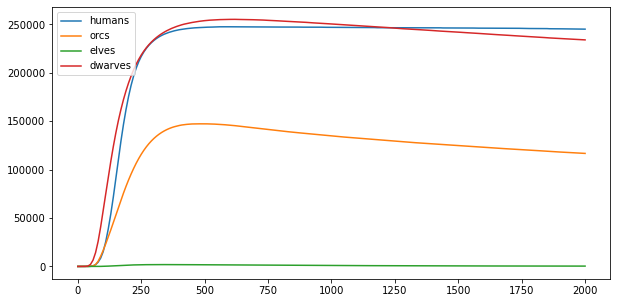

In [31]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
for rc in ThePops:
    ax.plot([10*t for t in demos.History["time"]],[np.sum(pop) for pop in demos.History[rc]], label = rc)
ax.legend()


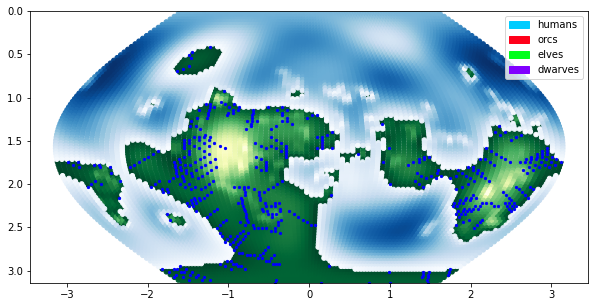

In [32]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')

nice_colors = [(0,0.8,1),(1,0,0.1),(0,1,0.1),(0.5,0,1),(1,1,0.1),(1,0.1,1)]

colors = {}
bascol = {}
ii=0
for pop in ThePops:
    c1,c2,c3 = nice_colors[ii]#np.random.rand(3)
    ii += 1
    bascol[pop] = (c1,c2,c3)
    colors[pop] =  LinearSegmentedColormap.from_list(pop+"mp", [(c1,c2,c3, 0.0),(c1,c2,c3, 0.5)])



# redmp = LinearSegmentedColormap.from_list('redmp', [(0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 0.0),(0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 1.0)])
# tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])

# BIGN = len(World1.GlobeGrid[0].flatten())

# ims = [ax.scatter(MapTheta.flatten(),World1.GlobeGrid[0].flatten(),s=20,c  = ar.flatten) for ar in demos.History["humans"]]
im = {}
for pop in ThePops:
    im[pop] = ax.scatter(MapTheta.flatten(),World1.GlobeGrid[0].flatten(),s=20,c  = demos.History[pop][0].flatten(),cmap =colors[pop])

    
patchs = [mpatches.Patch(color=(*col[1],1), label=col[0]) for col in bascol.items()]
ax.legend(handles=patchs)

    
def updatefig(pt):
    for i in ThePops:
        im[i].set_color(colors[i](demos.History[i][pt].flatten()))
#     im.set_color(redmp(pop.flatten()))
    return  im,

# fr = [[addAlpha(r.History["Genetics"][i],r.History["Population"][i]).reshape(BIGN,4) for r in raceOrder] for i in range(len(resources["Time"]))]


ani = animation.FuncAnimation(fig, updatefig,frames = range(len(demos.History["total"])), interval=200)#len(history["Time"])
with open("popSpread.html", "w") as f:
    print(ani.to_html5_video(), file=f)
HTML(ani.to_html5_video())

In [99]:
len(demos.History["time"])

101

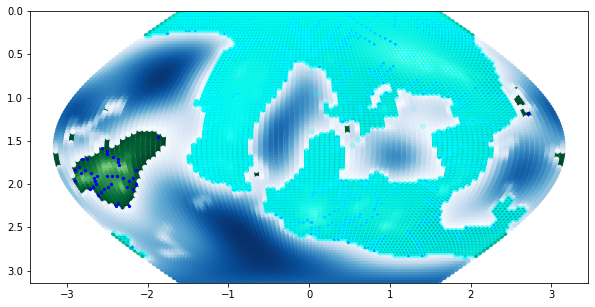

In [44]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')

tpt = -1
im = ax.scatter(MapTheta.flatten(),World1.GlobeGrid[0].flatten(),s=20,c  = demos.History["total"][tpt].flatten(),cmap = tlmap)

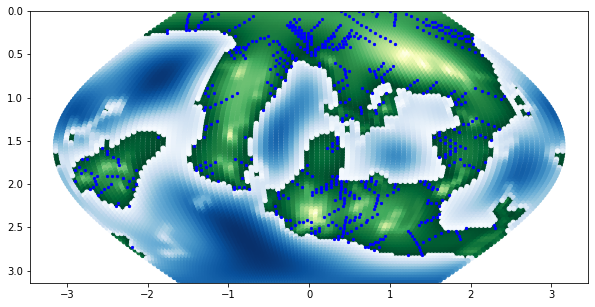

In [45]:
RotateView(World1,0)

In [37]:
def GetThetaSlice(data,theta1,theta2,world):

    
    numTheta = world.GlobeGrid[1].shape[0]
    
    data = np.concatenate([data,data[1:]])
    
    theThetas = np.concatenate([world.GlobeGrid[1],2*np.pi + world.GlobeGrid[1][1:]])

    startAngle = theta1
    startRow = np.where(world.GlobeGrid[1] >= startAngle)[0][0]
    
    data = data[startRow:startRow + numTheta]
    theThetas = theThetas[startRow:startRow + numTheta]
    
    if theta2>=theta1:
        stopAngle = theta2
    else:
        stopAngle = theta2 + 2*np.pi
                
    stopRow = np.where(theThetas >= stopAngle)[0][0]
    
    data = data[:stopRow]


    return data

In [38]:
def GetSubGrid(world,theta1,theta2):
    
    if theta2>=theta1:
        angleViewed = theta2 - theta1
    else:
        angleViewed = (np.pi - theta1) + (theta2 + np.pi)
            
    startAngle = -angleViewed/2
    stopAngle = angleViewed/2
    
    startRow = np.where(world.GlobeGrid[1] >= startAngle)[0][0]
    stopRow = np.where(world.GlobeGrid[1] >= stopAngle)[0][0]
    
    return world.GlobeGrid[0][startRow:stopRow],world.GlobeGrid[1][startRow:stopRow]

    

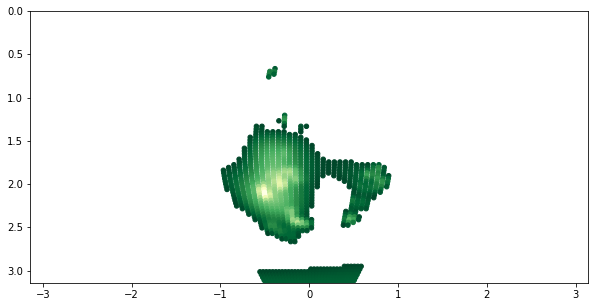

In [39]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.set_xlim(-np.pi,np.pi)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])

theta1,phi1 = (3*np.pi/5, np.pi/3)#NW corner
theta2,phi2 = (-3*np.pi/4, 2*np.pi/3)#SE Corner


subglobe = GetSubGrid(World1,theta1,theta2)
subMap = mapThetas(subglobe)

data3 = GetThetaSlice(World1.LandIndicator,theta1,theta2,World1)#World1.LandIndicator[phigrid]
data5 = GetThetaSlice(World1.Elevation,theta1,theta2,World1)#World1.Elevation[phigrid]

ax.scatter(subMap[data3],subglobe[0][data3],s=20, c = data5[data3], cmap = 'YlGn_r')

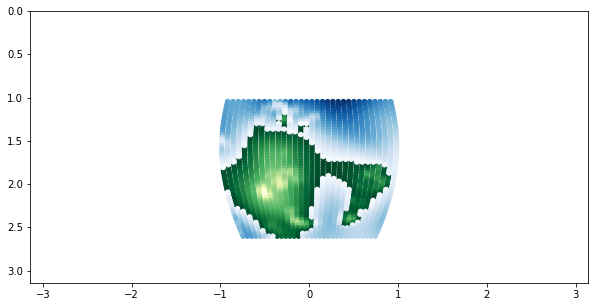

In [40]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
ax.set_xlim(-np.pi,np.pi)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])

theta1,phi1 = (3*np.pi/5, np.pi/3)#NW corner
theta2,phi2 = (-3*np.pi/4, 2.5*np.pi/3)#SE Corner



subglobe = GetSubGrid(World1,theta1,theta2)
subMap = mapThetas(subglobe)

data3 = GetThetaSlice(World1.LandIndicator,theta1,theta2,World1)#World1.LandIndicator[phigrid]
data5 = GetThetaSlice(World1.Elevation,theta1,theta2,World1)#World1.Elevation[phigrid]

boolPhi = (subglobe[0]>phi1)*(subglobe[0]<phi2)
phigrid = np.where(boolPhi)



data1 = subglobe[0][phigrid]
data2 = subMap[phigrid]
data3 = data3[phigrid]
data5 = data5[phigrid]

ax.scatter(data2[data3],data1[data3],s=20,c = data5[data3], cmap = 'YlGn_r')
ax.scatter(data2[np.invert(data3)],data1[np.invert(data3)],s=20,c = data5[np.invert(data3)], cmap = 'Blues_r')
# ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')



# tpt = -1
# im = ax.scatter(MapTheta.flatten(),World1.GlobeGrid[0].flatten(),s=20,c  = demos.History["total"][tpt].flatten(),cmap = tlmap)

In [41]:
np.where((World1.GlobeGrid[0]>np.pi/3)*(World1.GlobeGrid[0]<2*np.pi/3))

(array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64),
 array([33, 34, 35, ..., 63, 64, 65], dtype=int64))

In [42]:
def SqrPowers(pops,world):
    N_all = np.sum(world.LandIndicator)
    avg_pop_all = np.sum(pops)/N_all
    pop_var_all = np.sqrt(np.sum((pops- avg_pop_all)**2)/N_all)
    above_all = (pops - avg_pop_all)/pop_var_all
    
    final = above_all*world.LandIndicator

    final_floor = np.maximum(final,0.001*np.ones_like(final))
    
    return final_floor
    
    

In [299]:
num = []
for topop in demos.History["total"]:
    power = SqrPowers(topop,World1)
    exp = np.random.exponential(power)
    num += [np.sum(exp > 5)]

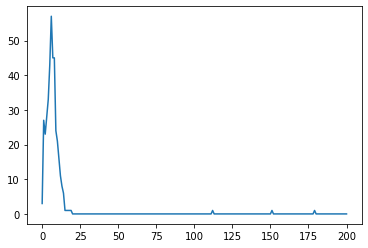

In [300]:
plt.plot(num)

In [98]:
def getPower(ci,countries,power):
    indices = np.where(countries == ci)
    return sum(powers[indices])

In [467]:
def NewCountries(pop,current_countries,current_index,world):
    new = ((powers > (3 + 3/(1 + 0.1*current_index)))*(current_countries[-1] == 0)).flatten()
    new_countries = current_countries.copy().flatten()
    newwhere = np.where(new)[0]
    for i in newwhere:
        neighbors = world.neighborkey[i]
        if all(current_countries.flatten()[neighbors] == 0):
            new_countries[neighbors] = current_index
            current_index += 1
    new_countries = new_countries.reshape(world.GridSize)
            
    return new_countries,current_index

In [228]:
def ExpandCountry(ci,countries,world):
    new_countries = countries.copy().flatten()
    country = np.where(countries.flatten() == ci)[0]
    for i in country:
        neighbors = world.neighborkey[i]
        for j in neighbors:
            if (new_countries[j] == 0) or (new_countries[j] == ci):
                new_countries[j] = ci
    return new_countries.reshape(countries.shape)

In [229]:
def DisbandCountry(ci,countries):
    countries[np.where(countries == ci)] == 0
    return countries

In [628]:
def ViveLeRevolution(country,countries,currentIndex,world):
    #Need to figure out how to divide a country!!!
    new_countries = countries.copy()
    borderpts = GetPerim(country,countries,world)
    locs = np.where(countries == country)
    num_sqs = len(locs[0])
    num_rebelled = 1
    if num_sqs > 3:
        starting_point = np.random.choice(borderpts)
        new_countries[np.unravel_index(starting_point,world.GridSize)] = currentIndex
        num_sqs = num_sqs - 1
        for j in world.neighborkey[starting_point]:
            if new_countries.flatten()[j] == country:
                new_countries[np.unravel_index(j,world.GridSize)] = currentIndex
                num_sqs = num_sqs - 1
        continuing = True
        while continuing:
            if num_sqs > 0:
                border_points = findBorder(country,currentIndex,new_countries,world)
                if len(border_points):
                    for bp in border_points:
                        new_countries[np.unravel_index(bp,world.GridSize)] = currentIndex
                        num_sqs = num_sqs - 1
                    if np.random.rand() < 0.5:
                        continuing = False
                else:
                    continuing = False
            else:
                continuing = False
        currentIndex += 1
        return new_countries,currentIndex
    else:
        return new_countries,currentIndex

In [231]:
def GetNeighborCountries(country,countries,world):
    fltlocs = np.where(countries.flatten() == country)[0]
    flcountries = countries.copy().flatten()
    neighbor_countries = []
    for i in fltlocs:
        neighbors = world.neighborkey[i]
        for j in neighbors:
            if (flcountries[j] != 0) and (flcountries[j] != country):
                neighbor_countries += [flcountries[j]]
    return np.unique(neighbor_countries)

In [602]:
def WhatIsItGoodFor(country,countries,power,world):
    neighborcs = GetNeighborCountries(country,countries,world)
    new_countries = countries.copy()
    if len(neighborcs):
        locpower = getPower(country,countries,power)
        neighborpowers = [getPower(ci,countries,power) for ci in neighborcs]
        powerRatios = [locpower/(locpower + np) for np in neighborpowers]
        totR = sum(powerRatios)
        probs = [pr/totR for pr in powerRatios]
        attacking = np.random.choice(neighborcs, p = probs)
        locs = np.where(countries == attacking)
        dpow = getPower(attacking,countries,power)
        if dpow > 0.6*locpower:
            fighting = True
            while fighting:
                border_points = findBorder(attacking,country,new_countries,world)
                if len(border_points):
                    for bp in border_points:
                        if np.random.rand() > dpow/(locpower + dpow):
                            new_countries[np.unravel_index(bp,world.GridSize)] = country
                    if np.random.rand() < 0.5:
                        fighting = False
                else:
                    fighting = False
        else:
            new_countries[locs] = country
    return new_countries

In [595]:
def findBorder(c1,c2,countries,world):
    c1locs = np.where(countries.flatten() == c1)[0]
    border_pts = []
    for loc in c1locs:
        if c2 in countries.flatten()[world.neighborkey[loc]]:
            border_pts += [loc]
    return border_pts

In [613]:
def GetPerim(c1,countries,world):
    c1locs = np.where(countries.flatten() == c1)[0]
    border_pts = []
    for loc in c1locs:
        if any(countries.flatten()[world.neighborkey[loc]] != c1):
            border_pts += [loc]
    return border_pts

In [629]:
countries = [np.zeros_like(demos.History["total"][0]).astype(int)]
country_index = 1

for pop in demos.History["total"]:
    powers = np.random.exponential(SqrPowers(pop,World1))
    new_countries,country_index = NewCountries(pop,countries[-1],country_index,World1)    
    for ci in range(1,country_index+1):
        power = getPower(ci,new_countries,powers)
        if power > 0:
            num_squares = len(np.where(new_countries == ci)[0])
            ppsq = power/max(1,num_squares)
            if power > 1:
                new_countries = ExpandCountry(ci,new_countries,World1)
            if np.random.exponential(ppsq) > 2:
                new_countries = WhatIsItGoodFor(ci,new_countries,powers,World1)
            elif power < 0.01:
                new_countries = DisbandCountry(ci,new_countries)
            elif ppsq<0.1 and num_squares>20:
                new_countries,country_index = ViveLeRevolution(ci,new_countries,country_index,World1)
                


    countries += [new_countries*World1.LandIndicator]
    
    

In [630]:
countrySizes = {}
for i in range(1,np.max(countries[-1])+1):
    countrySizes[i] = len(np.where(countries[-1] == i)[0])
existing_countries = [ky for ky in countrySizes.keys() if countrySizes[ky] > 0]
ec_dict = dict([(existing_countries[i],i) for i in range(len(existing_countries))])
num_countries = max(ec_dict.keys())
total_existing = len(ec_dict)

In [631]:
def GetCountryTotals(countries):
    countrySizes = {}
    for i in range(1,np.max(countries)+1):
        countrySizes[i] = len(np.where(countries == i)[0])
    existing_countries = [ky for ky in countrySizes.keys() if countrySizes[ky] > 0]
    ec_dict = dict([(existing_countries[i],i) for i in range(len(existing_countries))])
    num_countries = max(ec_dict.keys())
    total_existing = len(ec_dict)
    return countrySizes,ec_dict,num_countries,total_existing

In [632]:
num_countries,total_existing

(72, 48)

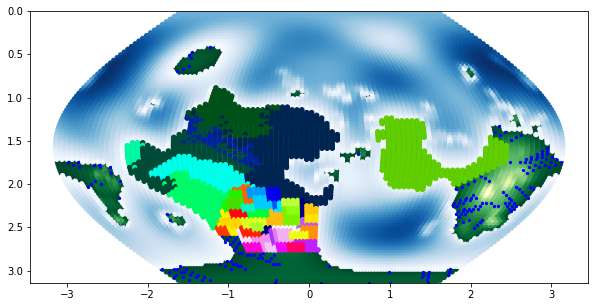

In [633]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = -1
ExistingColors = countries[tpt].copy()
for ii,jj in ec_dict.items():
    loc = np.where(countries[tpt] == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()>0],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()>0],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()>0],cmap = "gist_ncar")

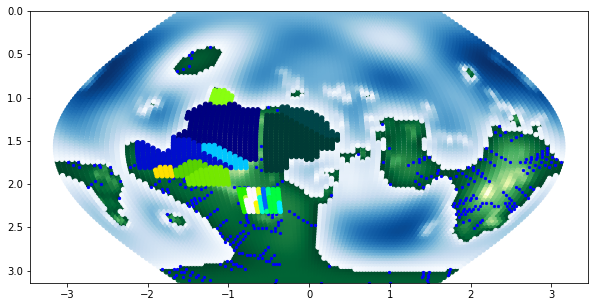

In [571]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = 10
ExistingColors = countries[tpt].copy()
for ii,jj in ec_dict.items():
    loc = np.where(countries[tpt] == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()>0],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()>0],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()>0],cmap = "gist_ncar")

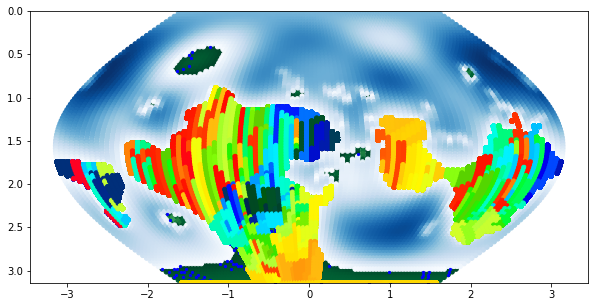

In [557]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')


im = ax.scatter(MapTheta.flatten()[countries[0].flatten()>0],World1.GlobeGrid[0].flatten()[countries[0].flatten()>0],s=20,c  = countries[0].flatten()[countries[0].flatten()>0],cmap = "gist_ncar")

country_norm = cmod.Normalize(vmin=0, vmax=num_countries)

def updatefig(pt):
    
    im = ax.scatter(MapTheta.flatten()[countries[pt].flatten()>0],World1.GlobeGrid[0].flatten()[countries[pt].flatten()>0],s=20,c  = countries[pt].flatten()[countries[pt].flatten()>0],cmap = "gist_ncar", norm = country_norm)

    return  im,

stop_time = 100
ani = animation.FuncAnimation(fig, updatefig,frames = range(stop_time), interval=200)#len(history["Time"])
with open("popSpread.html", "w") as f:
    print(ani.to_html5_video(), file=f)
HTML(ani.to_html5_video())

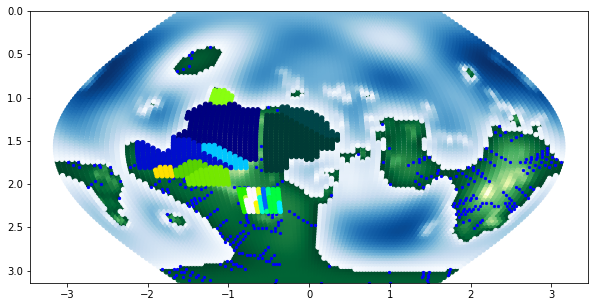

In [572]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = 10
ExistingColors = countries[tpt].copy()
for ii,jj in ec_dict.items():
    loc = np.where(countries[tpt] == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()>0],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()>0],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()>0],cmap = "gist_ncar")

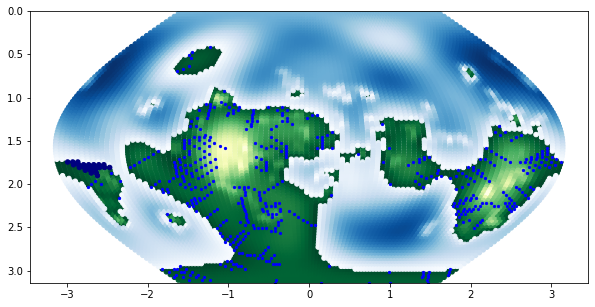

In [618]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = 10
ExistingColors = countries[tpt].copy()
cindx = 5
cnum = ec_dict[cindx]
for ii,jj in ec_dict.items():
    loc = np.where(countries[tpt] == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()==cnum],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()==cnum],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()==cnum],cmap = "gist_ncar")

In [615]:
GetPerim(5,countries[tpt],World1)

[255,
 355,
 356,
 455,
 456,
 457,
 556,
 557,
 558,
 656,
 658,
 659,
 756,
 757,
 758,
 759,
 760,
 856,
 857,
 956,
 957,
 1057]

In [592]:
np.max(countries[10])

33

In [509]:
test = countries[10].copy()

In [536]:
powers = np.random.exponential(SqrPowers(demos.History["total"][10],World1))
afterWar = new_countries = WhatIsItGoodFor(cindx,test,powers,World1)

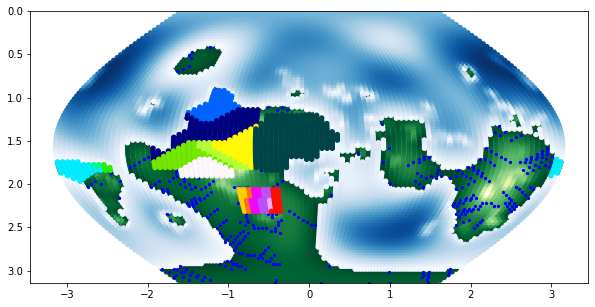

In [537]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = 10
ExistingColors =afterWar.copy()
for ii,jj in ec_dict.items():
    loc = np.where(afterWar == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()>0],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()>0],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()>0],cmap = "gist_ncar")

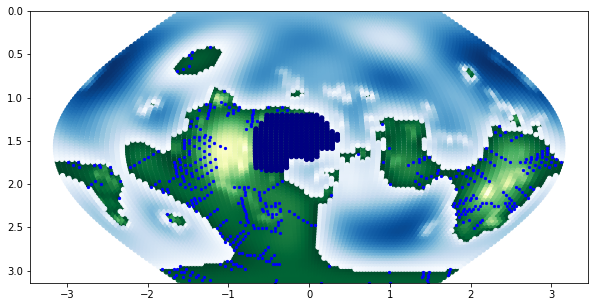

In [538]:
fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)
tlmap = LinearSegmentedColormap.from_list('tlmap', [(0, 1, 1, 0.0),(0, 1, 1, 1.0)])


ax.scatter(MapTheta[World1.LandIndicator],World1.GlobeGrid[0][World1.LandIndicator],s=20,c = World1.Elevation[World1.LandIndicator], cmap = 'YlGn_r')
ax.scatter(MapTheta[np.invert(World1.LandIndicator)],World1.GlobeGrid[0][np.invert(World1.LandIndicator)],s=20,c = World1.Elevation[np.invert(World1.LandIndicator)], cmap = 'Blues_r')
ax.scatter(MapTheta[RiverMsk],World1.GlobeGrid[0][RiverMsk],s=5,color = 'b')
# 
tpt = 10
ExistingColors = afterWar.copy()
cindx = 4
cnum = ec_dict[cindx]
for ii,jj in ec_dict.items():
    loc = np.where(afterWar == ii)
    ExistingColors[loc] = jj

im = ax.scatter(MapTheta.flatten()[ExistingColors.flatten()==cnum],World1.GlobeGrid[0].flatten()[ExistingColors.flatten()==cnum],s=20,c  = ExistingColors.flatten()[ExistingColors.flatten()==cnum],cmap = "gist_ncar")